# Prueba técnica W & J parte 3
- por David Ricardo Vivas Ordóñez

For this third challenge we will retrieve information regarding the authors of the dataset

In [ ]:
### datased download
!gdown --id 18g0n5IrhTc_7uJlUTYjnavgnjkPrPVJp

Downloading...
From: https://drive.google.com/uc?id=18g0n5IrhTc_7uJlUTYjnavgnjkPrPVJp
To: /content/News_Category_Dataset_v2.json
83.9MB [00:00, 117MB/s] 


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import nltk
import seaborn as sns
sns.set_theme(style="darkgrid")

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We will proceed to load our dataset a usual

In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v2.json', lines=True)
n_classes = df.category.nunique()
df['category'] = pd.Categorical(df['category'])

However, as now we are more interested in the author information of our dataset, we will proceed to
1. Discard articles with no author information (empty string is False)

In [ ]:
df = df[df['authors'].astype(bool)] # remove empty author entries

2. Tokenize the author column into arrays of words

In [ ]:
tokenized_authors = [ nltk.word_tokenize(item) for item in df['authors']]

3. Crop the author names to two words 

    Given that the general form of an author entry in this dataset is of the form 
        "author 1, ..., author n, organization 1, ..., organization n"
    I decided to consider only the main author (first author first name and lastname) for this exploration.Initially I considered using name entity extractors such as [6_line_ner](https://tim.mcnamara.nz/post/2650550090/extracting-names-with-6-lines-of-python-code) or [stanford_ner](https://nlp.stanford.edu/software/CRF-NER.html) and splitting entries with multiple authors into different entries, each with a different author. However, neither of these named entity recognizers performed well enough in my experiments. 


In [ ]:
def crop_entries(item, req_len = 2):
    '''
    crops a list of arrays to the desired length
    '''
    if len(item) <= req_len:
        return item
    else:
        return item[0:2]

df['authors'] = list(map(crop_entries, tokenized_authors))                                          # crop entries with more than 2 words to 2 words
df = df[df['authors'].map(len) == 2]                                                                # discard entries with less than 1 word 
df['authors'] = list(map(lambda arr : arr[0] + ' ' + arr[1], df['authors']))                        # concat our two-word author names
df['authors'] = pd.Categorical(df['authors']) 
df['authors_label'] = df['authors'].cat.codes
df['category_label'] = df['category'].cat.codes
authors = df['authors'].cat.categories
categories = df['category'].cat.categories
df = df.sort_index(axis=1)

Lets now inspect our data

In [ ]:
df.head()

,authors,authors_label,category,category_label,date,headline,link,short_description
0,Melissa Jeltsen,14241,CRIME,6,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,1292,ENTERTAINMENT,10,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [ ]:
uniques, counts = np.unique(df['authors_label'], return_counts = True)

The author with the highest number of written articles is

In [ ]:
print(authors[np.argmax(counts)], 'with', np.max(counts), 'articles.')
df[df['authors']==authors[np.argmax(counts)]]

Lee Moran with 2428 articles.


,authors,authors_label,category,category_label,date,headline,link,short_description
78,Lee Moran,12214,COMEDY,5,2018-05-24,'Late Night' Writer's Breathless Royal Wedding...,https://www.huffingtonpost.com/entry/royal-wed...,"“Then he bites his lip, like, ‘Hmm, girl.’”"
86,Lee Moran,12214,COMEDY,5,2018-05-24,Seth Meyers Gives Donald Trump Some Valuable M...,https://www.huffingtonpost.com/entry/seth-meye...,"“Stop trying to make ‘Fetch’ happen."""
99,Lee Moran,12214,POLITICS,24,2018-05-24,Chrissy Teigen Taunts Donald Trump Over Twitte...,https://www.huffingtonpost.com/entry/chrissy-t...,"Other tweeters, including Mexico's former pres..."
112,Lee Moran,12214,COMEDY,5,2018-05-24,Samantha Bee Torches ICE: 'Let's Shut It The F...,https://www.huffingtonpost.com/entry/samantha-...,"""I’m serious. It’s awful. And we don’t actuall..."
127,Lee Moran,12214,MEDIA,20,2018-05-24,Jake Tapper Shreds Donald Trump With A Long Li...,https://www.huffingtonpost.com/entry/jake-tapp...,"""I could go on, but this is just an hour show."""
...,...,...,...,...,...,...,...,...
74607,Lee Moran,12214,WEIRD NEWS,36,2015-11-15,The Weirdest Version Of MJ’s ‘Smooth Criminal’...,https://www.huffingtonpost.com/entry/michael-j...,The 1987 smash hit gets a pretty bizarre rewor...
74653,Lee Moran,12214,WEIRD NEWS,36,2015-11-15,"Dad Films Dream Vegas Vacation On Son's GoPro,...",https://www.huffingtonpost.com/entry/dream-vac...,Typical dad move.
74656,Lee Moran,12214,WEIRD NEWS,36,2015-11-15,Watch Bryan Cranston's 'Malcolm In The Middle'...,https://www.huffingtonpost.com/entry/malcolm-h...,We probably should have seen this coming.
74657,Lee Moran,12214,WEIRD NEWS,36,2015-11-15,Adorable Kittens Act Out Every Single 'Harry P...,https://www.huffingtonpost.com/entry/harry-pot...,Warning: Cuteness Overload


The average number of articles written per author is 


In [ ]:
print(np.mean(counts), 'articles with a dispersion of', np.std(counts, dtype=np.float64))

7.73249458109509 articles with a dispersion of 49.432936673305775


That is a huge dispersion! lets plot the number of written articles per author, sorted by frequency, and see why

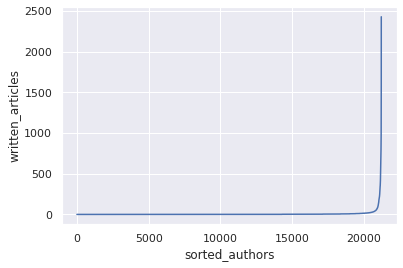

In [ ]:
dummy  = pd.DataFrame({'sorted_authors': np.arange(len(counts)), 'written_articles': np.sort(counts)})
sns.lineplot(data = dummy, x = 'sorted_authors', y = 'written_articles')
plt.show()

This distribution evidentiates that the vast majority or articles is written by a small fraction of the total different authors. This can be attributed to the fact that online newspapers have a core of main authors, but also many contributions from guests journalists and external contributors.

Lets see now the ammount of categories per author for authors that wrote 100 articles or more:

In [ ]:
higher_counts  = np.sort(counts)[counts >= 100]
higher_authors = np.argsort(uniques)[counts >= 100]

counts_per_author = []
for item in higher_authors:
    n_cats, _ = np.unique(df['category'][df['authors_label'] == item], return_counts = True)
    counts_per_author.append(n_cats)

dudu = [len(item) for item in counts_per_author]
print('The author with the widest scope of categories is', authors[higher_authors[np.argmax(dudu)]], 'with', np.max(dudu),'categories')
print('The mean ammount of different categories per author is', int(np.round(np.mean(dudu))))
df[df['authors']==authors[higher_authors[np.argmax(dudu)]]]

The author with the widest scope of categories is Ron Dicker with 38 categories
The mean ammount of different categories per author is 9


,authors,authors_label,category,category_label,date,headline,link,short_description
2,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."
5,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Morgan Freeman 'Devastated' That Sexual Harass...,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ..."
6,Ron Dicker,17466,ENTERTAINMENT,10,2018-05-26,Donald Trump Is Lovin' New McDonald's Jingle I...,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right."
...,...,...,...,...,...,...,...,...
198268,Ron Dicker,17466,BUSINESS,3,2012-02-25,Oscars 2012: How Much Money Is At Stake,https://www.huffingtonpost.com/entry/oscars-20...,Sunday's Academy Awards are all about celebrat...
198269,Ron Dicker,17466,BUSINESS,3,2012-02-25,Oscars 2012: Ads Grant Marketers An Advantage ...,https://www.huffingtonpost.com/entry/oscars-ad...,"Of course, Oscar spots won't reach nearly as m..."
198892,Ron Dicker,17466,BUSINESS,3,2012-02-18,Jeremy Lin Applies For Trademark On Linsanity,https://www.huffingtonpost.com/entry/jeremy-li...,"Now that Lin is defending his name, perhaps ev..."
199483,Ron Dicker,17466,BUSINESS,3,2012-02-12,"Jeremy Lin, Knicks Star, Shouldn't Be Too Quic...",https://www.huffingtonpost.com/entry/jeremy-li...,Branding wonks have thrown out many comparison...
